In [23]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, MultiTaskLasso, RidgeCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from joblib import Parallel, delayed

In [2]:
# Cargar y ordenar las tablas por orden alfabetico para comaprar correctamente las predicciones
X = pd.read_csv("data/BLOOD_EDA.csv", index_col=0).sort_index(axis=0)
X2 = pd.read_csv("data/BLOOD_EDA_minmax.csv", index_col=0).sort_index(axis=0)
Y = pd.read_csv("data/THYR_EDA.csv", index_col=0).sort_index(axis=0)

In [9]:
print("============= DATOS DE TABLAS =============")
print(f"\tTamaño de X: {X.shape[1]} genes")
print(f"\tTamaño de X: {X.shape[0]} muestras")
print(f"\tTamaño de Y: {Y.shape[1]} rutas")
print(f"\tTamaño de Y: {Y.shape[0]} muestras")

============= DATOS DE TABLAS =============
	Tamaño de X: 23182 genes
	Tamaño de X: 522 muestras
	Tamaño de Y: 1503 rutas
	Tamaño de Y: 522 muestras


In [10]:
# SPLIT 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

CONTROL DE SPLIT

In [46]:
X_train.iloc[:5, :5]

,1,2,3,9,10
GTEX-1CB4H-0006-SM-A96RE.1,-0.073499,1.513571,0.700997,-1.165980,-0.295706
GTEX-OXRP-0006-SM-2I3FN.1,-0.502086,-0.294025,-0.697959,-0.964517,0.704311
GTEX-1HCUA-0006-SM-ACKV9.1,-0.754156,-0.615776,-0.709576,0.153094,-0.295706
GTEX-14A5H-0006-SM-5O9AI.1,-0.744491,1.877070,1.209267,-0.986537,0.119194
GTEX-T5JW-0005-SM-3GADE.1,0.052658,-0.349150,-0.554121,-0.087539,-0.295706


In [12]:
Y_train.iloc[:5, :5]

,P-hsa03320-37,P-hsa03320-61,P-hsa03320-46,P-hsa03320-57,P-hsa03320-64
GTEX-1CB4H-0126-SM-7IGN2.1,1.391233,0.318582,0.398442,0.943887,-0.030341
GTEX-OXRP-0326-SM-33HBJ.1,-0.579340,-0.876393,0.946247,-0.153551,0.023281
GTEX-1HCUA-0126-SM-B2LWC.1,-0.089885,-0.046576,-0.167675,-0.318014,-0.366444
GTEX-14A5H-0726-SM-5Q5DW.1,-0.599464,-1.458136,-0.147443,0.470471,-0.663556
GTEX-T5JW-1226-SM-3GACY.1,-0.081802,-0.991420,-0.455053,-0.347122,-0.663556


In [13]:
X_test.iloc[:5, :5]

,1,2,3,9,10
GTEX-1B8SG-0006-SM-7MKFA.1,0.598251,-0.610088,0.988982,-0.999323,0.196828
GTEX-1PBJI-0005-SM-CJI1Y.1,3.969078,1.092658,0.496183,-0.188523,-0.295706
GTEX-Q734-0006-SM-2I3FJ.1,0.633956,1.167818,-0.260276,0.630324,-0.295706
GTEX-1KANC-0006-SM-9YFL8.1,-0.298187,-0.494084,-0.363324,1.157462,-0.295706
GTEX-1R9JW-0002-SM-DO93B.1,1.474760,-1.302697,-0.606276,0.533081,-0.295706


In [14]:
Y_test.iloc[:5, :5]

,P-hsa03320-37,P-hsa03320-61,P-hsa03320-46,P-hsa03320-57,P-hsa03320-64
GTEX-1B8SG-1126-SM-7IGMT.1,-0.576591,1.146472,0.435348,0.519948,0.750762
GTEX-1PBJI-0726-SM-EXUSQ.1,-0.532453,-0.272460,0.028455,-0.169818,-0.241394
GTEX-Q734-0526-SM-2I3EH.1,0.946960,-0.557046,-0.545809,-0.565946,-0.209159
GTEX-1KANC-0826-SM-D3LA8.1,-0.666131,0.776398,-0.569052,-0.423038,0.088292
GTEX-1R9JW-0226-SM-EVR4K.1,0.051625,-0.907097,-0.569052,-0.565946,-0.083453


In [15]:
print("Tamaño de X_train:", X_train.shape)
print("Tamaño de Y_train:", Y_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Tamaño de Y_test:", Y_test.shape)

Tamaño de X_train: (417, 23182)
Tamaño de Y_train: (417, 1503)
Tamaño de X_test: (105, 23182)
Tamaño de Y_test: (105, 1503)


In [16]:
if not os.path.exists("data/imagen"):
    os.makedirs("data/imagen")
if not os.path.exists("data/prediction"):
    os.makedirs("data/prediction")

In [18]:
#####------ PARALELIZACIÓN
# --- Configuración 
n_cores = 8 # núcleos 
block_size = 8  # columnas por bloque
alphas = np.logspace(-3, 3, 20) # configuración de alphas
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Nombre de ruta y archivo ---
results_file = "data/prediction/results_ridgecv.csv"
pred_file = "data/prediction/predicciones_ridgecv.csv"

# --- Tamaño de la nueva matriz
n_cols = Y_train.shape[1]
n_rows = Y_test.shape[0]

# Inicialización archivo para predicciones en pandas si no existe
if os.path.exists(pred_file):
    pred_df = pd.read_csv(pred_file, index_col=0)
else:
    pred_df = pd.DataFrame(np.zeros((n_rows, n_cols)), columns=[f"Vía {i}" for i in range(n_cols)])

# Lectura resultados previos si existen
if os.path.exists(results_file):
    try:
        result = pd.read_csv(results_file)
        # Verificar si el archivo no está vacío y tiene datos
        if not result.empty and 'Salida' in result.columns:
            # Extraer números de manera segura, manejando posibles NaN
            extracted = result['Salida'].str.extract(r'Vía (\d+)')
            if not extracted.empty:
                processed_cols = set(extracted[0].dropna().astype(int))
            else:
                processed_cols = set()
        else:
            processed_cols = set()
            result = pd.DataFrame()
    except (pd.errors.EmptyDataError, KeyError):
        # Si el archivo está vacío o corrupto
        processed_cols = set()
        result = pd.DataFrame()
else:
    result = pd.DataFrame()
    processed_cols = set()

# --- Función para entrenar y evaluar ---
def entrenar_y_evaluar(i):
    nombre_via = Y_train.columns[i]  
    modelo = RidgeCV(alphas=alphas, cv=kf, scoring='r2')
    modelo.fit(X_train, Y_train.iloc[:, i])
    Y_pred = modelo.predict(X_test)
    return {
        "Salida": f"Vía {i}",
        "Alpha seleccionado (CV)": modelo.alpha_,
        "R2 (test)": r2_score(Y_test.iloc[:, i], Y_pred),
        "MAE (test)": mean_absolute_error(Y_test.iloc[:, i], Y_pred),
        "MSE (test)": mean_squared_error(Y_test.iloc[:, i], Y_pred),
        "Y_pred": Y_pred
    }

# --- Procesamiento por bloques, se procesa cada 8 filas ---
start_time = time.time()

for start_idx in range(0, n_cols, block_size):
    end_idx = min(start_idx + block_size, n_cols)
    block_range = [i for i in range(start_idx, end_idx) if i not in processed_cols]
    
    if not block_range:
        print(f"Bloque {start_idx}-{end_idx-1} ya procesado, saltando...")
        continue
    
    print(f"\nProcesando columnas {block_range[0]} a {block_range[-1]} ...")
    
    # Paralelizar el bloque
    block_results = Parallel(n_jobs=n_cores, verbose=10)(
        delayed(entrenar_y_evaluar)(i) for i in block_range
    )
    
    # Guardar métricas y predicciones
    new_result = []
    for res in block_results:
        # Extraer el número de la vía del string "Vía X"
        via_num = res['Salida'].split(' ')[1]  # obtiene el número después de "Vía"
        pred_df[f"Vía {via_num}"] = res['Y_pred']
        new_result.append({k: v for k, v in res.items() if k != 'Y_pred'})
    
    # Guardar resultados
    new_result = pd.DataFrame(new_result)
    
    # Escribir en el archivo CSV
    if os.path.exists(results_file) and not pd.read_csv(results_file).empty:
        new_result.to_csv(results_file, mode='a', index=False, header=False)
    else:
        new_result.to_csv(results_file, mode='w', index=False, header=True)
    
    pred_df.to_csv(pred_file)
    
    elapsed = (time.time() - start_time)/60
    print(f"Bloque completado. Tiempo transcurrido: {elapsed:.1f} min")

total_elapsed = (time.time() - start_time)/3600
print(f"\n✅ Entrenamiento completo de {n_cols} columnas finalizado en {total_elapsed:.2f} horas")
print(f"Resultados guardados en '{results_file}' y predicciones en '{pred_file}'")


Procesando columnas 0 a 7 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   40.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 2.0 min

Procesando columnas 8 a 15 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 4.0 min

Procesando columnas 16 a 23 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 5.9 min

Procesando columnas 24 a 31 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 7.9 min

Procesando columnas 32 a 39 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 9.8 min

Procesando columnas 40 a 47 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 11.8 min

Procesando columnas 48 a 55 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 13.7 min

Procesando columnas 56 a 63 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 15.7 min

Procesando columnas 64 a 71 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 17.7 min

Procesando columnas 72 a 79 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 19.6 min

Procesando columnas 80 a 87 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 21.6 min

Procesando columnas 88 a 95 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 23.5 min

Procesando columnas 96 a 103 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  6.0min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 25.5 min

Procesando columnas 104 a 111 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.1min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 27.5 min

Procesando columnas 112 a 119 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 29.5 min

Procesando columnas 120 a 127 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 31.4 min

Procesando columnas 128 a 135 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 33.4 min

Procesando columnas 136 a 143 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 35.4 min

Procesando columnas 144 a 151 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 37.3 min

Procesando columnas 152 a 159 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 39.3 min

Procesando columnas 160 a 167 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  6.0min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 41.3 min

Procesando columnas 168 a 175 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 43.3 min

Procesando columnas 176 a 183 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 45.3 min

Procesando columnas 184 a 191 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 47.2 min

Procesando columnas 192 a 199 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 49.2 min

Procesando columnas 200 a 207 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 51.2 min

Procesando columnas 208 a 215 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 53.1 min

Procesando columnas 216 a 223 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 55.1 min

Procesando columnas 224 a 231 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 57.1 min

Procesando columnas 232 a 239 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 59.1 min

Procesando columnas 240 a 247 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   40.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 61.1 min

Procesando columnas 248 a 255 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 63.1 min

Procesando columnas 256 a 263 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 65.0 min

Procesando columnas 264 a 271 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 67.0 min

Procesando columnas 272 a 279 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 69.0 min

Procesando columnas 280 a 287 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 70.9 min

Procesando columnas 288 a 295 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 72.9 min

Procesando columnas 296 a 303 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.1min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 74.8 min

Procesando columnas 304 a 311 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 76.8 min

Procesando columnas 312 a 319 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 78.8 min

Procesando columnas 320 a 327 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 80.8 min

Procesando columnas 328 a 335 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 82.7 min

Procesando columnas 336 a 343 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 84.7 min

Procesando columnas 344 a 351 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 86.6 min

Procesando columnas 352 a 359 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 88.6 min

Procesando columnas 360 a 367 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 90.6 min

Procesando columnas 368 a 375 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 92.6 min

Procesando columnas 376 a 383 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 94.6 min

Procesando columnas 384 a 391 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.1min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 96.5 min

Procesando columnas 392 a 399 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 98.7 min

Procesando columnas 400 a 407 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.1min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 100.6 min

Procesando columnas 408 a 415 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.1min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 102.6 min

Procesando columnas 416 a 423 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 104.5 min

Procesando columnas 424 a 431 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 106.5 min

Procesando columnas 432 a 439 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 108.5 min

Procesando columnas 440 a 447 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 110.4 min

Procesando columnas 448 a 455 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 112.4 min

Procesando columnas 456 a 463 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 114.3 min

Procesando columnas 464 a 471 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 116.3 min

Procesando columnas 472 a 479 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 118.3 min

Procesando columnas 480 a 487 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 120.2 min

Procesando columnas 488 a 495 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 122.2 min

Procesando columnas 496 a 503 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 124.2 min

Procesando columnas 504 a 511 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  6.0min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 126.2 min

Procesando columnas 512 a 519 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 128.2 min

Procesando columnas 520 a 527 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 130.1 min

Procesando columnas 528 a 535 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 132.1 min

Procesando columnas 536 a 543 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 134.1 min

Procesando columnas 544 a 551 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 136.1 min

Procesando columnas 552 a 559 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.1min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 138.0 min

Procesando columnas 560 a 567 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 140.0 min

Procesando columnas 568 a 575 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 141.9 min

Procesando columnas 576 a 583 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 143.9 min

Procesando columnas 584 a 591 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 145.8 min

Procesando columnas 592 a 599 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 147.8 min

Procesando columnas 600 a 607 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 149.8 min

Procesando columnas 608 a 615 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 151.8 min

Procesando columnas 616 a 623 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 153.7 min

Procesando columnas 624 a 631 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 155.7 min

Procesando columnas 632 a 639 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 157.7 min

Procesando columnas 640 a 647 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 159.6 min

Procesando columnas 648 a 655 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 161.6 min

Procesando columnas 656 a 663 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 163.6 min

Procesando columnas 664 a 671 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 165.6 min

Procesando columnas 672 a 679 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 167.5 min

Procesando columnas 680 a 687 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 169.5 min

Procesando columnas 688 a 695 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 171.5 min

Procesando columnas 696 a 703 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 173.4 min

Procesando columnas 704 a 711 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 175.4 min

Procesando columnas 712 a 719 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 177.4 min

Procesando columnas 720 a 727 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 179.3 min

Procesando columnas 728 a 735 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 181.3 min

Procesando columnas 736 a 743 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 183.3 min

Procesando columnas 744 a 751 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 185.2 min

Procesando columnas 752 a 759 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 187.2 min

Procesando columnas 760 a 767 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 189.2 min

Procesando columnas 768 a 775 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 191.1 min

Procesando columnas 776 a 783 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 193.1 min

Procesando columnas 784 a 791 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 195.1 min

Procesando columnas 792 a 799 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 197.1 min

Procesando columnas 800 a 807 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.6min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 199.0 min

Procesando columnas 808 a 815 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 201.0 min

Procesando columnas 816 a 823 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 202.9 min

Procesando columnas 824 a 831 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 204.9 min

Procesando columnas 832 a 839 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 206.9 min

Procesando columnas 840 a 847 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 208.9 min

Procesando columnas 848 a 855 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 210.8 min

Procesando columnas 856 a 863 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 212.8 min

Procesando columnas 864 a 871 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 214.7 min

Procesando columnas 872 a 879 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 216.7 min

Procesando columnas 880 a 887 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 218.6 min

Procesando columnas 888 a 895 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 220.6 min

Procesando columnas 896 a 903 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 222.6 min

Procesando columnas 904 a 911 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 224.5 min

Procesando columnas 912 a 919 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 226.5 min

Procesando columnas 920 a 927 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 228.4 min

Procesando columnas 928 a 935 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 230.3 min

Procesando columnas 936 a 943 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 232.3 min

Procesando columnas 944 a 951 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 234.3 min

Procesando columnas 952 a 959 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 236.2 min

Procesando columnas 960 a 967 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 238.2 min

Procesando columnas 968 a 975 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 240.1 min

Procesando columnas 976 a 983 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 242.1 min

Procesando columnas 984 a 991 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 244.0 min

Procesando columnas 992 a 999 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 246.0 min

Procesando columnas 1000 a 1007 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 248.0 min

Procesando columnas 1008 a 1015 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 249.9 min

Procesando columnas 1016 a 1023 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 251.9 min

Procesando columnas 1024 a 1031 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 253.9 min

Procesando columnas 1032 a 1039 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 255.8 min

Procesando columnas 1040 a 1047 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 257.8 min

Procesando columnas 1048 a 1055 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 259.8 min

Procesando columnas 1056 a 1063 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 261.7 min

Procesando columnas 1064 a 1071 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 263.7 min

Procesando columnas 1072 a 1079 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 265.6 min

Procesando columnas 1080 a 1087 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 267.6 min

Procesando columnas 1088 a 1095 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 269.6 min

Procesando columnas 1096 a 1103 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 271.6 min

Procesando columnas 1104 a 1111 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 273.6 min

Procesando columnas 1112 a 1119 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 275.5 min

Procesando columnas 1120 a 1127 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 277.5 min

Procesando columnas 1128 a 1135 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 279.5 min

Procesando columnas 1136 a 1143 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 281.4 min

Procesando columnas 1144 a 1151 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 283.4 min

Procesando columnas 1152 a 1159 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 285.4 min

Procesando columnas 1160 a 1167 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 287.4 min

Procesando columnas 1168 a 1175 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.1min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 289.3 min

Procesando columnas 1176 a 1183 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 291.3 min

Procesando columnas 1184 a 1191 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 293.3 min

Procesando columnas 1192 a 1199 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 295.2 min

Procesando columnas 1200 a 1207 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 297.2 min

Procesando columnas 1208 a 1215 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 299.2 min

Procesando columnas 1216 a 1223 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 301.2 min

Procesando columnas 1224 a 1231 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 303.2 min

Procesando columnas 1232 a 1239 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 305.1 min

Procesando columnas 1240 a 1247 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 307.1 min

Procesando columnas 1248 a 1255 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 309.1 min

Procesando columnas 1256 a 1263 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 311.1 min

Procesando columnas 1264 a 1271 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 313.1 min

Procesando columnas 1272 a 1279 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 315.0 min

Procesando columnas 1280 a 1287 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.6min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.1min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 317.0 min

Procesando columnas 1288 a 1295 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 318.9 min

Procesando columnas 1296 a 1303 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.1min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 320.9 min

Procesando columnas 1304 a 1311 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 322.8 min

Procesando columnas 1312 a 1319 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 324.8 min

Procesando columnas 1320 a 1327 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 326.8 min

Procesando columnas 1328 a 1335 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 328.8 min

Procesando columnas 1336 a 1343 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 330.7 min

Procesando columnas 1344 a 1351 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 332.7 min

Procesando columnas 1352 a 1359 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 334.7 min

Procesando columnas 1360 a 1367 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 336.6 min

Procesando columnas 1368 a 1375 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 338.6 min

Procesando columnas 1376 a 1383 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 340.6 min

Procesando columnas 1384 a 1391 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 342.6 min

Procesando columnas 1392 a 1399 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 344.6 min

Procesando columnas 1400 a 1407 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.1min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 346.5 min

Procesando columnas 1408 a 1415 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 348.5 min

Procesando columnas 1416 a 1423 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 350.5 min

Procesando columnas 1424 a 1431 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 352.4 min

Procesando columnas 1432 a 1439 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 354.4 min

Procesando columnas 1440 a 1447 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 356.4 min

Procesando columnas 1448 a 1455 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 358.4 min

Procesando columnas 1456 a 1463 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 360.3 min

Procesando columnas 1464 a 1471 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 362.3 min

Procesando columnas 1472 a 1479 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.0min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.0min remaining:   39.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Bloque completado. Tiempo transcurrido: 364.3 min

Procesando columnas 1480 a 1487 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 366.2 min

Procesando columnas 1488 a 1495 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.9min remaining:   38.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Bloque completado. Tiempo transcurrido: 368.2 min

Procesando columnas 1496 a 1502 ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done   2 out of   7 | elapsed:  1.6min remaining:  4.1min
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:  1.6min remaining:  2.2min
[Parallel(n_jobs=8)]: Done   4 out of   7 | elapsed:  1.7min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   5 out of   7 | elapsed:  1.8min remaining:   42.6s
[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:  1.8min finished


Bloque completado. Tiempo transcurrido: 370.0 min

✅ Entrenamiento completo de 1503 columnas finalizado en 6.17 horas
Resultados guardados en 'data/prediction/results_ridgecv.csv' y predicciones en 'data/prediction/predicciones_ridgecv.csv'


In [25]:

result = pd.read_csv("data/prediction/results_ridgecv.csv", index_col=0).sort_index(axis=0)
result.index = Y_train.columns[:len(result)]
result.iloc[0:10,]

,Alpha seleccionado (CV),R2 (test),MAE (test),MSE (test)
P-hsa03320-37,1000.0,0.055180,0.696149,1.056939
P-hsa03320-61,1000.0,0.178994,0.817290,0.996403
P-hsa03320-46,1000.0,0.118818,0.711292,0.840396
P-hsa03320-57,1000.0,-0.145331,0.759561,1.134965
P-hsa03320-64,1000.0,0.352622,0.590250,0.592889
P-hsa03320-47,1000.0,0.043062,0.736190,0.927043
P-hsa03320-65,1000.0,0.274225,0.693649,0.792680
P-hsa03320-55,1000.0,0.012099,0.790069,0.960882
P-hsa03320-56,1000.0,-0.052291,0.698713,0.744677
P-hsa03320-33,1000.0,0.098859,0.726080,0.812687


In [26]:
new = pd.DataFrame(result)
new.shape

(1503, 4)

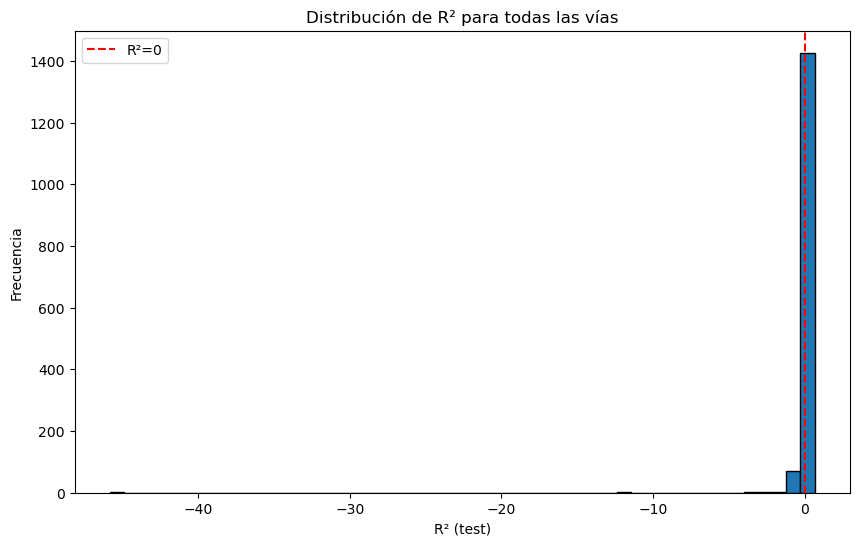

R² mediano: 0.0653942416617904
% vías con R²>0: 61.6%
% vías con R²>0.1: 41.7%


In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(result['R2 (test)'], bins=50, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='R²=0')
plt.xlabel('R² (test)')
plt.ylabel('Frecuencia')
plt.title('Distribución de R² para todas las vías')
plt.legend()
plt.show()

# Estadísticas
print(f"R² mediano: {result['R2 (test)'].median()}")
print(f"% vías con R²>0: {(result['R2 (test)'] > 0).mean()*100:.1f}%")
print(f"% vías con R²>0.1: {(result['R2 (test)'] > 0.1).mean()*100:.1f}%")


=== ESTADÍSTICAS BÁSICAS ===
R² mínimo: -45.810
R² máximo: 0.658
R² mediano: 0.065
R² promedio: 0.015
Desviación estándar: 1.244

=== PORCENTAJES DE RENDIMIENTO ===
% vías con R² > 0: 61.6%
% vías con R² > 0.1: 41.7%
% vías con R² > 0.3: 11.0%
% vías con R² > 0.5: 1.3%

=== MEJORES 10 VÍAS POR R² ===
                  Alpha seleccionado (CV)  R2 (test)  MAE (test)  MSE (test)
P-hsa04211-50                      1000.0   0.658141    0.484981    0.360920
P-hsa04014-61                      1000.0   0.605543    0.510577    0.413838
P-hsa04152-30                      1000.0   0.599190    0.499168    0.404006
P-hsa04910-14                      1000.0   0.582337    0.539403    0.462488
P-hsa04933-21                      1000.0   0.580562    0.470643    0.377659
P-hsa04024-108                     1000.0   0.574219    0.452272    0.371643
P-hsa05212-8                       1000.0   0.569264    0.456847    0.387700
P-hsa05110-12                      1000.0   0.544108    0.550816    0.466163
P-hsa

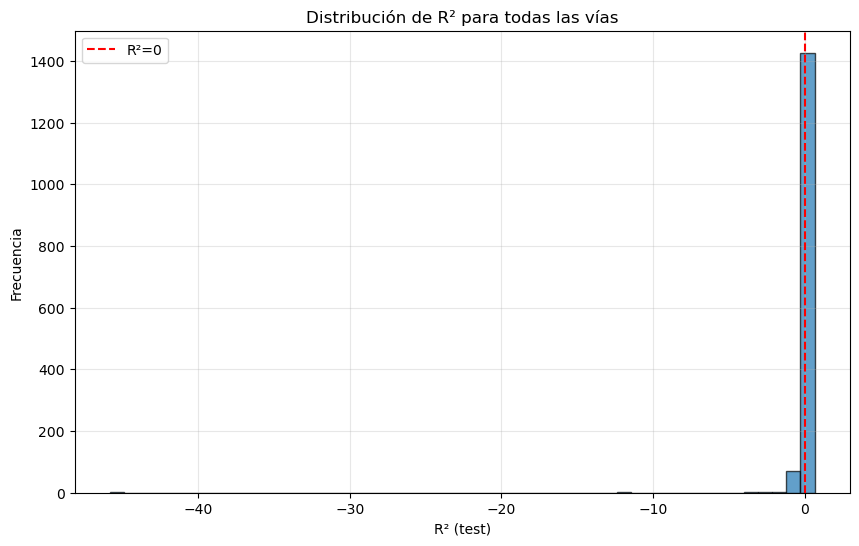

In [42]:

# Estadísticas básicas
print("=== ESTADÍSTICAS BÁSICAS ===")
print(f"R² mínimo: {result['R2 (test)'].min():.3f}")
print(f"R² máximo: {result['R2 (test)'].max():.3f}")
print(f"R² mediano: {result['R2 (test)'].median():.3f}")
print(f"R² promedio: {result['R2 (test)'].mean():.3f}")
print(f"Desviación estándar: {result['R2 (test)'].std():.3f}")
print()

# Porcentajes de vías con buen rendimiento
print("=== PORCENTAJES DE RENDIMIENTO ===")
print(f"% vías con R² > 0: {(result['R2 (test)'] > 0).mean()*100:.1f}%")
print(f"% vías con R² > 0.1: {(result['R2 (test)'] > 0.1).mean()*100:.1f}%")
print(f"% vías con R² > 0.3: {(result['R2 (test)'] > 0.3).mean()*100:.1f}%")
print(f"% vías con R² > 0.5: {(result['R2 (test)'] > 0.5).mean()*100:.1f}%")
print()

print("=== MEJORES 10 VÍAS POR R² ===")
resul_altos = result.sort_values("R2 (test)", ascending=False)
print(resul_altos.head(10))

print("\n=== PEORES 10 VÍAS POR R² ===")
resul_bajos = result.sort_values("R2 (test)", ascending=True)
print(resul_bajos.head(10))

# Análisis de los resultados
plt.figure(figsize=(10, 6))
plt.hist(result['R2 (test)'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='R²=0')
plt.xlabel('R² (test)')
plt.ylabel('Frecuencia')
plt.title('Distribución de R² para todas las vías')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


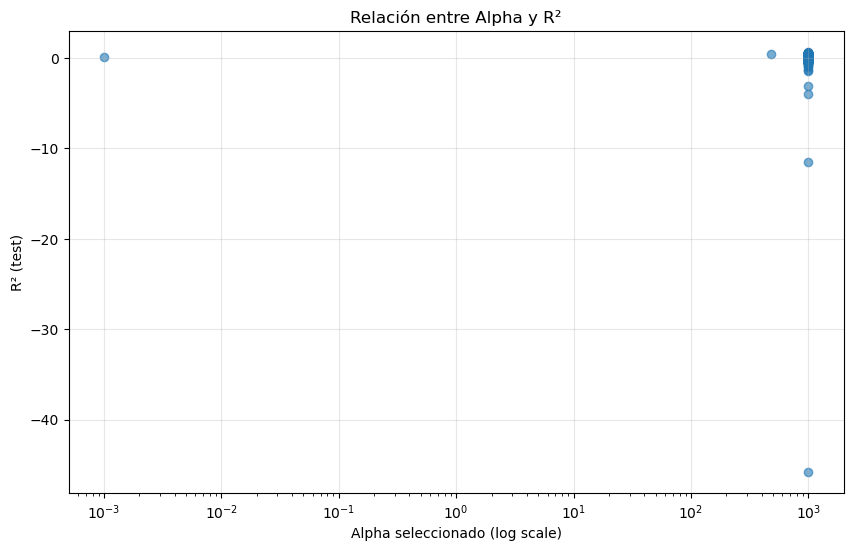

In [31]:
# Scatter plot R² vs Alpha
plt.figure(figsize=(10, 6))
plt.scatter(result['Alpha seleccionado (CV)'], result['R2 (test)'], alpha=0.6)
plt.xscale('log')
plt.xlabel('Alpha seleccionado (log scale)')
plt.ylabel('R² (test)')
plt.title('Relación entre Alpha y R²')
plt.grid(alpha=0.3)
plt.show()

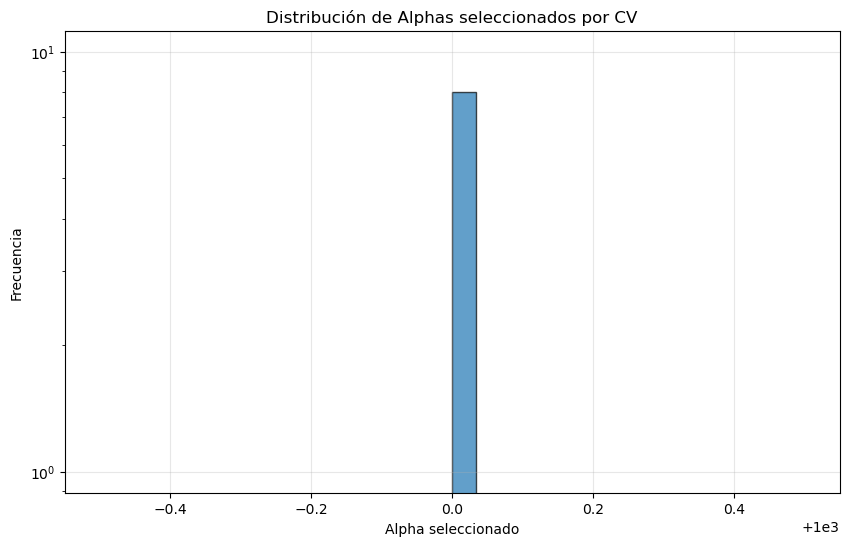

In [61]:

# 1. Análisis de Alphas
plt.figure(figsize=(10, 6))
plt.hist(results_df['Alpha seleccionado (CV)'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Alpha seleccionado')
plt.ylabel('Frecuencia')
plt.title('Distribución de Alphas seleccionados por CV')
plt.yscale('log')  # Escala logarítmica si los alphas varían mucho
plt.grid(alpha=0.3)
plt.show()